## Hackaton

In [1]:
"""WARNING MESSAGE 숨감"""
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as fm
f_path = "C:/windows/Fonts/malgun.ttf"
fm.FontProperties(fname=f_path).get_name()
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
from PIL import Image
from skimage.transform import resize
from tqdm import tqdm
import gc
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

In [3]:
"""GPU 환경 설정하기"""
from tensorflow.python.client import device_lib
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

"""tensorflow 환경에서 GPU 사용 여부 확인"""
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10321921137676159558
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22718447616
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8295074075195142387
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

#### 데이터 분석 (10점)

##### 데이터 불러오기

In [ ]:
# json 파일 분석
file_path = "./S63_DATA1/C1/E63_DATA1_C1_L3_D2023-09-06-21-53_031_000001.json"
with open(file_path, 'r', encoding='utf8') as file:
    data = json.load(file)

##### 데이터 및 데이터 타입 확인

In [ ]:
# 데이터 타입 확인
print(type(data))

In [ ]:
# 데이터 key 확인
print(data.keys())

In [ ]:
# key 별 데이터 확인
print("data_info: {}".format(data["data_info"]))
print()
print("categories: {}".format(data["categories"]))
print()
print("class: {}".format(data["class"]))
print()
print("images: {}".format(data["images"]))
print()
print("annotations: {}".format(data["annotations"]))

In [ ]:
print("class name: {}".format(data["class"][0]["name"]))
print("class name: {}".format(data["class"][1]["name"]))

In [ ]:
# 이미지 데이터 확인
img = Image.open("./S63_DATA1/C1/E63_DATA1_C1_L3_D2023-09-06-21-53_031_000001.jpg")
plt.imshow(img)

In [ ]:
print(np.array(img).max(), np.array(img).min())

##### 데이터셋 생성

In [ ]:
DATA1_path = "./S63_DATA1"
DATA1_lst = os.listdir(DATA1_path)

In [ ]:
DATA1_lst

In [ ]:
# 메모리 지우기
import gc
gc.collect()

In [ ]:
def create_dataset(category_list=['C1', 'G1', 'H1', 'I1', 'T1']):
    X = []
    y = []
    for category in category_list:
        # 카테고리별 데이터 개수 파악
        img_lst = glob.glob(DATA1_path + "/" + category + "/*.jpg")
        # 카테고리별 데이터 셋 생성
        for idx in tqdm(range(len(img_lst))):
            img_path = img_lst[idx]
            img = np.array(Image.open(img_path))
            resized_img = resize(img, (224, 224, 3), preserve_range=True, anti_aliasing=True)/255.0
            X.append(resized_img)
            y.append(category)
    return X, y

In [ ]:
X, y = create_dataset()

In [ ]:
print(len(X), len(y))

In [ ]:
# 메모리 지우기
import gc
gc.collect()

In [ ]:
print(X[0].shape)

In [ ]:
X = np.array(X)
print(X.max(), X.min(), X.mean())

In [ ]:
# 정답 데이터의 One hot Encoding 작업

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
enc.fit(np.array(y).reshape(-1, 1))
y_enc = enc.transform(np.array(y).reshape(-1, 1))

In [ ]:
print(y_enc[0])
print(y_enc[6000])
print(y_enc[12000])
print(y_enc[18000])
print(y_enc[24000])

In [ ]:
import pickle
# pkl 저장
with open('X_224.pickle', 'wb') as f:
    pickle.dump(X, f)
with open('y.pickle', 'wb') as f:
    pickle.dump(y_enc, f)

##### 저장된 데이터셋 불러오기

In [4]:
import pickle
# pkl 저장
with open('X_224.pickle', 'rb') as f:
    X = pickle.load(f)

In [5]:
with open('y.pickle', 'rb') as f:
    y_enc = pickle.load(f)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, stratify=y_enc, random_state=42, test_size = 0.2)

In [7]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(24000, 224, 224, 3) (24000, 5)
(6000, 224, 224, 3) (6000, 5)


#### 모델 알고리즘 (30점)

In [ ]:
# 메모리 지우기
import gc
gc.collect()

In [8]:
def create_None_model():
    model = EfficientNetB0(weights=None, include_top=True, input_shape=(224, 224, 3), classes=5)
    return model

In [9]:
def create_model():
    efnb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=5)

    model = Sequential()
    model.add(efnb0)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    
    return model

In [ ]:
B0_model = create_None_model()
cnn_model = create_model()

In [ ]:
B0_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
B0_model.summary()

In [ ]:
cnn_model.summary()

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [ ]:
B0_history = B0_model.fit(X_train[0:10000], y_train[0:10000], verbose=1, epochs=5, batch_size=8, validation_split=0.2)

In [ ]:
cnn_history = cnn_model.fit(X_train[0:10000], y_train[0:10000], verbose=1, epochs=5, batch_size=8, validation_split=0.2)

In [ ]:
B0_model.evaluate(X_test, y_test)

In [ ]:
cnn_model.evaluate(X_test, y_test)

In [10]:
def train_model(num, method=[1, 2, 3]):
    
    # 메모리 초기화
    gc.collect()
    print("메모리 초기화 완료.")
    model_lst = []
    history_lst = []
    
    if 1 in method:
        # stratifiedKfold
        print("Started Stratified K-fold...")
        str_kf = StratifiedKFold(n_splits=num, random_state=42, shuffle=True)
        # split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
        idx=0
        for train_index, test_index in str_kf.split(X_train, y_train.argmax(1)):
            X_train_kf, X_valid_kf = X_train[train_index], X_train[test_index]
            y_train_kf, y_valid_kf = y_train[train_index], y_train[test_index]
            kfold_model = create_None_model()
            kfold_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
            history = kfold_model.fit(X_train_kf, y_train_kf, verbose=1, epochs=10, batch_size=8, validation_data=(X_valid_kf, y_valid_kf))
            idx+=1
            model_lst.append(kfold_model)
            history_lst.append(history)
            gc.collect()
            print("({}/{})...Finished!".format(idx+1, num))
            print()
    
    elif 2 in method:
        print("Merge Model is started learning....")
        # 통합모델
        sum_model = create_None_model()
        sum_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
        for i in range(num):
            ranges = int(len(X_train)/num)
            print("{}/{}".format(i+1, num))
            history = sum_model.fit(X_train[ranges*i:ranges*(i+1)], y_train[ranges*i:ranges*(i+1)], verbose=1, epochs=30, batch_size=8, validation_split=0.2)
        model_lst.append(sum_model)
        history_lst.append(history)
        gc.collect()
        print("Merge Model learning is finished!!!!")
        print()
    
    elif 3 in method:
        print("Each Models are started learning...")
        # 개별모델
        for i in range(num):
            ranges = int(len(X_train)/num)
            each_model = create_None_model()
            each_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
            print("Start: {}, End: {}".format(ranges*i, ranges*(i+1)))

            # 데이터
            print("SHAPE: {} / {}".format(X_train[ranges*i:ranges*(i+1)].shape, y_train[ranges*i:ranges*(i+1)].shape))
            history = each_model.fit(X_train[ranges*i:ranges*(i+1)], y_train[ranges*i:ranges*(i+1)], verbose=1, epochs=10, batch_size=8, validation_split=0.2)
            model_lst.append(each_model)
            history_lst.append(history)
            gc.collect()
            print("({}/{})...Finished!".format(i+1, num))
            print()

    return model_lst, history_lst

In [11]:
kfold_model_lst, kfold_history_lst = train_model(3, [1])

메모리 초기화 완료.
Started Stratified K-fold...
Epoch 1/10
2000/2000 [==============================] - 140s 61ms/step - loss: 0.3771 - accuracy: 0.9097 - val_loss: 0.7996 - val_accuracy: 0.9107
Epoch 2/10
2000/2000 [==============================] - 117s 59ms/step - loss: 0.0587 - accuracy: 0.9845 - val_loss: 0.0022 - val_accuracy: 0.9998
Epoch 3/10
2000/2000 [==============================] - 119s 60ms/step - loss: 0.0415 - accuracy: 0.9890 - val_loss: 0.0033 - val_accuracy: 0.9989
Epoch 4/10
2000/2000 [==============================] - 117s 59ms/step - loss: 0.0307 - accuracy: 0.9908 - val_loss: 2.2914e-05 - val_accuracy: 1.0000
Epoch 5/10
2000/2000 [==============================] - 119s 59ms/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 1.8682e-06 - val_accuracy: 1.0000
Epoch 6/10
2000/2000 [==============================] - 118s 59ms/step - loss: 0.0242 - accuracy: 0.9936 - val_loss: 0.3048 - val_accuracy: 0.9454
Epoch 7/10
2000/2000 [==============================] - 118s 59ms/ste

In [19]:
idx=0
for i in kfold_model_lst:
    i.save("kforld_model_{}.h5".format(idx))
    idx+=1

In [12]:
one_model_lst, one_history_lst = train_model(3, [2])

메모리 초기화 완료.
Merge Model is started learning....
1/3
Epoch 1/30
800/800 [==============================] - 52s 59ms/step - loss: 0.7385 - accuracy: 0.8300 - val_loss: 1.3976 - val_accuracy: 0.5694
Epoch 2/30
800/800 [==============================] - 45s 57ms/step - loss: 0.0960 - accuracy: 0.9741 - val_loss: 0.1174 - val_accuracy: 0.9606
Epoch 3/30
800/800 [==============================] - 46s 57ms/step - loss: 0.0784 - accuracy: 0.9787 - val_loss: 0.2868 - val_accuracy: 0.9506
Epoch 4/30
800/800 [==============================] - 46s 57ms/step - loss: 0.0445 - accuracy: 0.9867 - val_loss: 0.0228 - val_accuracy: 0.9919
Epoch 5/30
800/800 [==============================] - 46s 57ms/step - loss: 0.0720 - accuracy: 0.9795 - val_loss: 6.4792e-05 - val_accuracy: 1.0000
Epoch 6/30
800/800 [==============================] - 46s 57ms/step - loss: 0.0256 - accuracy: 0.9927 - val_loss: 1.2056e-04 - val_accuracy: 1.0000
Epoch 7/30
800/800 [==============================] - 46s 57ms/step - loss: 

In [20]:
idx=0
for i in one_model_lst:
    i.save("one_model_{}.h5".format(idx))
    idx+=1

In [13]:
each_model_lst, each_history_lst = train_model(3, [3])

메모리 초기화 완료.
Each Models are started learning...
Start: 0, End: 8000
SHAPE: (8000, 224, 224, 3) / (8000, 5)
Epoch 1/10
800/800 [==============================] - 50s 57ms/step - loss: 0.7490 - accuracy: 0.8358 - val_loss: 0.2074 - val_accuracy: 0.9200
Epoch 2/10
800/800 [==============================] - 44s 55ms/step - loss: 0.0943 - accuracy: 0.9708 - val_loss: 0.8062 - val_accuracy: 0.8181
Epoch 3/10
800/800 [==============================] - 43s 54ms/step - loss: 0.0670 - accuracy: 0.9805 - val_loss: 1.6267 - val_accuracy: 0.8981
Epoch 4/10
800/800 [==============================] - 44s 55ms/step - loss: 0.0557 - accuracy: 0.9837 - val_loss: 0.0447 - val_accuracy: 0.9819
Epoch 5/10
800/800 [==============================] - 43s 54ms/step - loss: 0.0652 - accuracy: 0.9822 - val_loss: 3.1563e-04 - val_accuracy: 1.0000
Epoch 6/10
800/800 [==============================] - 44s 55ms/step - loss: 0.0502 - accuracy: 0.9861 - val_loss: 0.0025 - val_accuracy: 0.9987
Epoch 7/10
800/800 [=====

In [22]:
idx=0
for i in each_model_lst:
    i.save("each_model_{}.h5".format(idx))
    idx+=1

#### 모델 검증 (20점)

In [23]:
for i in kfold_model_lst:
    i.evaluate(X_test, y_test)

188/188 [==============================] - 5s 22ms/step - loss: 2.3286e-05 - accuracy: 1.0000


In [24]:
for i in one_model_lst:
    i.evaluate(X_test, y_test)

188/188 [==============================] - 5s 22ms/step - loss: 4.4900e-08 - accuracy: 1.0000


In [27]:
for i in each_model_lst:
    i.evaluate(X_test, y_test)

188/188 [==============================] - 5s 22ms/step - loss: 1.5527e-06 - accuracy: 1.0000


In [32]:
gc.collect()

4490

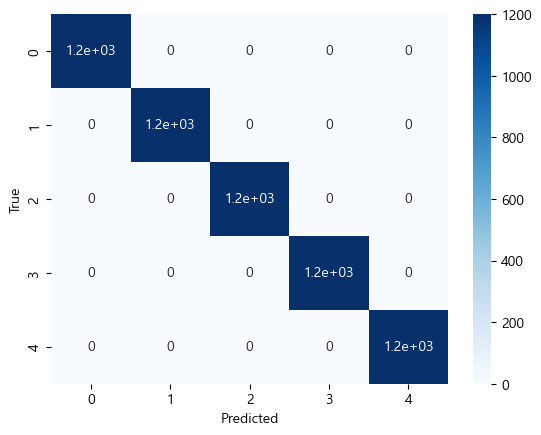

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = one_model_lst[0].predict(X_test)
cm = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [39]:
def predict_model(img_path, label):
    img = np.array(Image.open(img_path))
    resized_img = resize(img, (224, 224, 3), preserve_range=True, anti_aliasing=True)/255.0
    pred = np.argmax(one_model.predict(resized_img.reshape(1, 224, 224, 3)), axis=1)
    category_list = ['C1', 'G1', 'H1', 'I1', 'T1']
    if category_list[int(pred)] == label:
        print("Success!")
    else:
        print("Failed...")
    return pred

#### 적용 가능성 (20점)

#### 전달력 (20점)